# Prepare Raw Data 

This notebook takes a raw matrix, a filtered matrix, and metadata to create a workable .h5ad file for scAgent

In [71]:
# imports 
import pandas as pd
import scanpy as sc
import numpy as np
import os
import scipy
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scvi
# optional: nicer plots
sc.settings.verbosity = 2
sc.logging.print_header()

KeyboardInterrupt: 

In [ ]:
print("Testing scAR availability...")
try:
    import scvi
    from scvi.external import SCAR
    print(f"✓ scvi-tools available (version {scvi.__version__})")
    scar_available = True
except ImportError as e:
    print(f"✗ scvi-tools not available: {e}")
    scar_available = False

Testing scAR availability...
✓ scvi-tools available (version 1.4.0)


In [ ]:
import os
from pathlib import Path


## Import Data

In [ ]:

# Data pathsData_files/raw_data
DATA_DIR = Path('/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/Data_files/raw_data')
RAW_H5 = DATA_DIR / '7_raw_feature_bc_matrix.h5'
FILTERED_H5 = DATA_DIR / '7_filtered_feature_bc_matrix.h5'
META_CSV = DATA_DIR / 'metadata.xlsx - Sheet1.csv'


print(f"✓ Setup complete")
print(f"  Raw H5: {RAW_H5.exists()}")
print(f"  Filtered H5: {FILTERED_H5.exists()}")
print(f"  Metadata CSV: {META_CSV.exists()}")

✓ Setup complete
  Raw H5: True
  Filtered H5: True
  Metadata CSV: True


## View data

In [ ]:
# Load raw and filtered data
print("Loading data...")
raw = sc.read_10x_h5(str(RAW_H5))
filtered = sc.read_10x_h5(str(FILTERED_H5))
meta = pd.read_csv(str(META_CSV), index_col=0)

# Make var_names unique
raw.var_names_make_unique()
filtered.var_names_make_unique()

# Add metadata to filtered
sample_id = meta.index[0]
for col in meta.columns:
    filtered.obs[col] = meta.loc[sample_id, col]

# Save raw counts
filtered.layers['counts_raw'] = filtered.X.copy()

print(f"✓ Data loaded")
print(f"  Raw: {raw.shape}")
print(f"  Filtered: {filtered.shape}")
print(f"  Sample ID: {sample_id}")

Loading data...
reading /Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/Data_files/raw_data/7_raw_feature_bc_matrix.h5
 (0:00:01)
reading /Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/Data_files/raw_data/7_filtered_feature_bc_matrix.h5


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
✓ Data loaded
  Raw: (1617288, 32285)
  Filtered: (8877, 32285)
  Sample ID: 7Dataset


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
meta.index.values[0]

'7Dataset'

In [ ]:
filtered.obs['sample_ID'] = meta.index.values[0]

In [ ]:
filtered.obs['sample_ID']

AAACCCAAGGAAGTGA-1    7Dataset
AAACCCACACTACAGT-1    7Dataset
AAACCCACAGGTGGAT-1    7Dataset
AAACCCAGTCGTACTA-1    7Dataset
AAACCCATCGTTACCC-1    7Dataset
                        ...   
TTTGTTGGTACACTCA-1    7Dataset
TTTGTTGGTGTCCGTG-1    7Dataset
TTTGTTGGTTACAGCT-1    7Dataset
TTTGTTGTCGCCTCTA-1    7Dataset
TTTGTTGTCTAAACGC-1    7Dataset
Name: sample_ID, Length: 8877, dtype: object

In [ ]:
def compute_qc_metrics(adata, name=''):
    """Compute QC metrics for AnnData object."""
    X = adata.X
    
    if sp.issparse(X):
        total_counts = np.ravel(X.sum(axis=1))
        n_genes = np.ravel((X > 0).sum(axis=1))
    else:
        total_counts = X.sum(axis=1)
        n_genes = (X > 0).sum(axis=1)
    
    adata.obs['total_counts'] = total_counts
    adata.obs['n_genes'] = n_genes
    
    # Mitochondrial genes
    mt_mask = adata.var_names.str.upper().str.startswith('MT-')
    adata.var['mt'] = mt_mask
    
    if mt_mask.sum() > 0:
        if sp.issparse(X):
            mito_counts = np.ravel(X[:, mt_mask].sum(axis=1))
        else:
            mito_counts = X[:, mt_mask].sum(axis=1)
        adata.obs['pct_mito'] = mito_counts / adata.obs['total_counts'] * 100
    else:
        adata.obs['pct_mito'] = 0
    
    metrics = {
        'name': name,
        'mean_total_counts': float(total_counts.mean()),
        'median_total_counts': float(np.median(total_counts)),
        'std_total_counts': float(total_counts.std()),
        'mean_n_genes': float(n_genes.mean()),
        'median_n_genes': float(np.median(n_genes)),
        'std_n_genes': float(n_genes.std()),
        'mean_pct_mito': float(adata.obs['pct_mito'].mean()),
        'n_cells': adata.n_obs,
        'n_genes': adata.n_vars
    }
    return metrics

# Compute baseline metrics
baseline_metrics = compute_qc_metrics(filtered.copy(), 'baseline')
print("✓ QC metrics computed")
print(f"  Mean counts: {baseline_metrics['mean_total_counts']:.2f}")
print(f"  Mean genes: {baseline_metrics['mean_n_genes']:.2f}")
print(f"  Mean % mito: {baseline_metrics['mean_pct_mito']:.2f}")

✓ QC metrics computed
  Mean counts: 6366.95
  Mean genes: 2255.71
  Mean % mito: 0.69


In [75]:
import datetime
date = datetime.datetime(2025, 10, 18)
print(date)

2025-10-18 00:00:00


`Trainer.fit` stopped: `max_epochs=10` reached.
      ✓ Model trained
[6/6] Generating denoised counts...

============================================================
✓ SCAR denoising complete!
============================================================
Results stored in filtered_adata.layers:
  - 'counts'   : Original count matrix
  - 'denoised' : Ambient-corrected counts

You can now use filtered_adata.layers['denoised'] for downstream analysis
Step 2: QC filtering...
AnnData object with n_obs × n_vars = 8877 × 32285
    obs: 'animal_species', 'sex', 'age', 'tissue_type', 'treatment', 'processing_date', 'sample_type', 'sample_ID', 'total_counts', 'n_genes', 'pct_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'mt'
    obsm: 'X_scar'
    layers: 'counts_raw', 'denoised'

In [ ]:
print("Testing scAR availability...")
try:
    import scvi
    from scvi.external import SCAR
    print(f"✓ scvi-tools available (version {scvi.__version__})")
    scar_available = True
except ImportError as e:
    print(f"✗ scvi-tools not available: {e}")
    scar_available = False

Testing scAR availability...
✓ scvi-tools available (version 1.4.0)


In [ ]:
raw

AnnData object with n_obs × n_vars = 1617288 × 32285
    var: 'gene_ids', 'feature_types', 'genome'

In [ ]:
import time


In [ ]:
filtered

AnnData object with n_obs × n_vars = 8877 × 32285
    obs: 'animal_species', 'sex', 'age', 'tissue_type', 'treatment', 'processing_date', 'sample_type'
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'counts_raw'

In [ ]:
filtered.obs.head()

,animal_species,sex,age,tissue_type,treatment,processing_date,sample_type
AAACCCAAGGAAGTGA-1,mouse,M,3M2D,kidney,veh,20220701,snRNAseq
AAACCCACACTACAGT-1,mouse,M,3M2D,kidney,veh,20220701,snRNAseq
AAACCCACAGGTGGAT-1,mouse,M,3M2D,kidney,veh,20220701,snRNAseq
AAACCCAGTCGTACTA-1,mouse,M,3M2D,kidney,veh,20220701,snRNAseq
AAACCCATCGTTACCC-1,mouse,M,3M2D,kidney,veh,20220701,snRNAseq


In [ ]:
filtered.var.head()

,gene_ids,feature_types,genome
Xkr4,ENSMUSG00000051951,Gene Expression,mm10
Gm1992,ENSMUSG00000089699,Gene Expression,mm10
Gm19938,ENSMUSG00000102331,Gene Expression,mm10
Gm37381,ENSMUSG00000102343,Gene Expression,mm10
Rp1,ENSMUSG00000025900,Gene Expression,mm10


In [ ]:
filtered.var_names

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1',
       ...
       'Gm16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', length=32285)

In [ ]:
filtered.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 20023954 stored elements and shape (8877, 32285)>

In [ ]:
def compute_qc_metrics(adata, name=''):
    """Compute QC metrics for AnnData object."""
    X = adata.X
    
    if sp.issparse(X):
        total_counts = np.ravel(X.sum(axis=1))
        n_genes = np.ravel((X > 0).sum(axis=1))
    else:
        total_counts = X.sum(axis=1)
        n_genes = (X > 0).sum(axis=1)
    
    adata.obs['total_counts'] = total_counts
    adata.obs['n_genes'] = n_genes
    
    # Mitochondrial genes
    mt_mask = adata.var_names.str.upper().str.startswith('MT-')
    adata.var['mt'] = mt_mask
    
    if mt_mask.sum() > 0:
        if sp.issparse(X):
            mito_counts = np.ravel(X[:, mt_mask].sum(axis=1))
        else:
            mito_counts = X[:, mt_mask].sum(axis=1)
        adata.obs['pct_mito'] = mito_counts / adata.obs['total_counts'] * 100
    else:
        adata.obs['pct_mito'] = 0
    
    metrics = {
        'name': name,
        'mean_total_counts': float(total_counts.mean()),
        'median_total_counts': float(np.median(total_counts)),
        'std_total_counts': float(total_counts.std()),
        'mean_n_genes': float(n_genes.mean()),
        'median_n_genes': float(np.median(n_genes)),
        'std_n_genes': float(n_genes.std()),
        'mean_pct_mito': float(adata.obs['pct_mito'].mean()),
        'n_cells': adata.n_obs,
        'n_genes': adata.n_vars
    }
    return metrics

# Compute baseline metrics
baseline_metrics = compute_qc_metrics(filtered.copy(), 'baseline')
print("✓ QC metrics computed")
print(f"  Mean counts: {baseline_metrics['mean_total_counts']:.2f}")
print(f"  Mean genes: {baseline_metrics['mean_n_genes']:.2f}")
print(f"  Mean % mito: {baseline_metrics['mean_pct_mito']:.2f}")

✓ QC metrics computed
  Mean counts: 6366.95
  Mean genes: 2255.71
  Mean % mito: 0.69


## Ambient RNA

In [ ]:
scar_available = True
if scar_available:
    print("\\n" + "="*80)
    print("Running scAR...")
    print("="*80)
    
   
    
    try:
        # Make copies
        adata_scar = filtered.copy()
        raw_scar = raw.copy()
        
        # Set seed for reproducibility
        np.random.seed(42)
        
        # Setup AnnData
        print("1. Setting up AnnData...")
        SCAR.setup_anndata(adata_scar)
        print("   ✓ Setup complete")
        
        # Get ambient profile
        print("2. Estimating ambient profile...")
        SCAR.get_ambient_profile(adata=adata_scar, raw_adata=raw_scar, prob=0.995)
        print("   ✓ Ambient profile estimated")
        
        # Initialize model
        print("3. Initializing SCAR model...")
        scar_model = SCAR(adata_scar, ambient_profile="ambient_profile")
        print("   ✓ Model initialized")
        
        # Train
        print("4. Training model (this may take a few minutes)...")
        scar_model.train(
            max_epochs=100,
            batch_size=32,
            early_stopping=True,
            early_stopping_patience=10,
            train_size=0.9
        )
        print("   ✓ Training complete")
        
        # Get denoised counts
        print("5. Extracting denoised counts...")
        denoised = scar_model.get_denoised_counts()
        adata_scar.X = denoised
        print("   ✓ Denoised counts extracted")
        
        # Get latent representation
        print("6. Extracting latent representation...")
        latent = scar_model.get_latent_representation()
        adata_scar.obsm['X_scAR'] = latent
        print(f"   ✓ Latent representation: {latent.shape}")
        
        
        
        
        
        # Compute metrics
        scar_metrics = compute_qc_metrics(adata_scar, 'scAR')
        
        
        print(f"  Mean counts (corrected): {scar_metrics['mean_total_counts']:.2f}")
        print(f"  Mean genes: {scar_metrics['mean_n_genes']:.2f}")
     
        
    except Exception as e:
        print(f"✗ scAR failed: {type(e).__name__}: {e}")
        import traceback
        traceback.print_exc()
        scar_metrics = None
else:
    print("⊘ Skipping scAR (not installed)")
    scar_metrics = None

\n================================================================================
Running scAR...
1. Setting up AnnData...
   ✓ Setup complete
2. Estimating ambient profile...
Randomly sampling 50000 droplets to calculate the ambient profile.
Working...:  33%|███▎      | 1/3 [00:10<00:20, 10.07s/it]

/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scvi/external/scar/_model.py:252: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  raw_adata.obs["log_prob"] = log_prob


Working...: 100%|██████████| 3/3 [00:25<00:00,  8.66s/it]

/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scvi/train/_trainrunner.py:82: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottl


   ✓ Ambient profile estimated
3. Initializing SCAR model...
   ✓ Model initialized
4. Training model (this may take a few minutes)...
Epoch 100/100: 100%|██████████| 100/100 [19:43<00:00, 12.03s/it, v_num=1, train_loss=6.7e+3] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [19:43<00:00, 11.83s/it, v_num=1, train_loss=6.7e+3]
   ✓ Training complete
5. Extracting denoised counts...
   ✓ Denoised counts extracted
6. Extracting latent representation...
   ✓ Latent representation: (8877, 15)
  Mean counts (corrected): 5396.79
  Mean genes: 2523.56


## Ambient RNA Using Knee Plot

In [ ]:
adata_scar 

AnnData object with n_obs × n_vars = 8877 × 32285
    obs: 'animal_species', 'sex', 'age', 'tissue_type', 'treatment', 'processing_date', 'sample_type', '_scvi_batch', '_scvi_labels', 'total_counts', 'n_genes', 'pct_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'mt'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_scAR'
    varm: 'ambient_profile'
    layers: 'counts_raw'

In [ ]:
filtered

AnnData object with n_obs × n_vars = 8877 × 32285
    obs: 'animal_species', 'sex', 'age', 'tissue_type', 'treatment', 'processing_date', 'sample_type', 'total_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'counts_raw'

In [ ]:
min_counts = 3
import seaborn as sns

/var/folders/yl/pwzbfdbj3t750krq7cky4n5c0000gn/T/ipykernel_97584/2073673337.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(


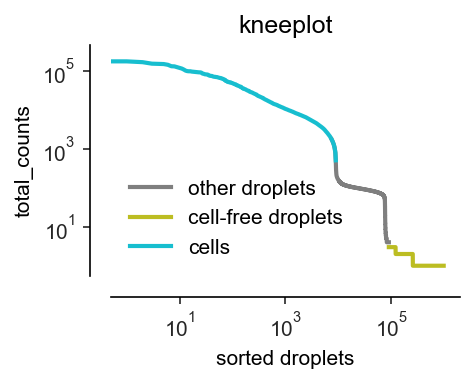

In [ ]:
all_droplets = pd.DataFrame(raw.X.sum(axis=1), index=raw.obs_names, columns=['total_counts'])
all_droplets['droplets'] = 'cell-free droplets'
all_droplets['droplets'] = all_droplets['droplets'].mask(all_droplets['total_counts']>min_counts, 'other droplets')
all_droplets['droplets'] = all_droplets['droplets'].mask(all_droplets.index.isin(filtered.obs_names), 'cells')
all_droplets.index.name = 'barcode'
all_droplets = all_droplets.sort_values(by='total_counts', ascending=False).reset_index().rename_axis("rank").reset_index()
all_droplets = all_droplets.loc[all_droplets['total_counts']>0]
all_droplets = all_droplets.set_index('barcode').rename_axis('cells')

plt.figure(figsize=(3, 2), dpi=150)
ax = sns.lineplot(
    data=all_droplets,
    x='rank',
    y='total_counts',
    hue='droplets',
    hue_order=['other droplets', 'cell-free droplets', 'cells'],
    palette=sns.color_palette()[-3:],
    markers=False,
    lw=2,
    ci=None
)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('sorted droplets');
ax.legend(loc='lower left', ncol=1, title=None, frameon=False)
ax.set_title(f'kneeplot')
sns.set_palette('muted')
sns.set_style('ticks')
sns.despine(offset=10, trim=False)

cell_free = raw[raw.obs_names.isin(all_droplets[all_droplets['droplets']=='cell-free droplets'].index)].copy()
cell_free = cell_free[:, filtered.var_names]
# average and normalize the transcript in cell-free droplets
ambient_profile = pd.DataFrame((cell_free.X.sum(axis=0)/cell_free.X.sum()).A1, index=filtered.var_names, columns=['ambient profile'])

In [ ]:

def denoise_with_scar(raw_adata, filtered_adata, max_epochs=10, prob=0.995):
    """
    Remove ambient RNA from filtered counts using SCAR model trained on raw data.
    
    Follows the scVI-tools SCAR workflow:
    1. Estimate ambient profile from raw (unfiltered) droplets
    2. Train SCAR model to learn cell-specific denoising
    3. Apply denoised counts to filtered cells
    
    Parameters:
    -----------
    raw_adata : AnnData
        Raw (unfiltered) count matrix with all droplets
    filtered_adata : AnnData
        Filtered count matrix (cells only)
    max_epochs : int
        Number of epochs to train SCAR model (default: 10)
    prob : float
        Probability threshold for ambient profile estimation (default: 0.995)
        Higher = more conservative in identifying cell-free droplets
    
    Returns:
    --------
    filtered_adata : AnnData
        Updated with denoised counts in layers['denoised']
    """
    
    print("=" * 60)
    print("SCAR: Ambient RNA Removal")
    print("=" * 60)
    
    # Step 1: Prepare raw data
    print("\n[1/6] Preparing raw data for ambient profile estimation...")
    raw_for_scar = raw_adata.copy()
    filtered_for_scar = filtered_adata.copy()
    
    # Ensure counts layer exists
    if 'counts' not in filtered_for_scar.layers:
        filtered_for_scar.layers['counts'] = filtered_for_scar.X.copy()
    
    # Step 2: Setup SCAR for raw data
    print("[2/6] Setting up SCAR for raw data...")
    SCAR.setup_anndata(filtered_for_scar)
    
    # Step 3: Estimate ambient profile using EmptyDrops-inspired method
    print("[3/6] Estimating ambient profile from raw data...")
    print(f"      Using probability threshold: {prob}")
    SCAR.get_ambient_profile(adata=filtered_for_scar, raw_adata=raw_for_scar, prob=prob)
    print(f"      ✓ Ambient profile saved to raw_adata.varm['ambient_profile']")
    
    # Step 4: Train SCAR model on raw data
    print(f"[4/6] Training SCAR model on raw data (max_epochs={max_epochs})...")
    scar_model = SCAR(filtered_for_scar, ambient_profile="ambient_profile")
    scar_model.train(max_epochs=max_epochs)
    print(f"      ✓ Model trained")
    

    # Step 5: Get denoised counts for filtered cells
    print("[6/6] Generating denoised counts...")
    denoised_counts = scar_model.get_denoised_counts()

    
    # Store denoised counts in layers
    filtered_adata.layers['denoised'] = denoised_counts
    filtered_adata.obsm['X_scar'] = scar_model.get_latent_representation()
    
    print("\n" + "=" * 60)
    print("✓ SCAR denoising complete!")
    print("=" * 60)
    print(f"Results stored in filtered_adata.layers:")
    print(f"  - 'counts'   : Original count matrix")
    print(f"  - 'denoised' : Ambient-corrected counts")
    print(f"\nYou can now use filtered_adata.layers['denoised'] for downstream analysis")
    
    return filtered_adata

# Run SCAR denoising on filtered data using raw for ambient profile
filtered = denoise_with_scar(raw, filtered, max_epochs=3, prob=0.995)


SCAR: Ambient RNA Removal

[1/6] Preparing raw data for ambient profile estimation...
[2/6] Setting up SCAR for raw data...
[3/6] Estimating ambient profile from raw data...
      Using probability threshold: 0.995
Randomly sampling 50000 droplets to calculate the ambient profile.
Working...:  33%|███▎      | 1/3 [00:11<00:22, 11.12s/it]

/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scvi/external/scar/_model.py:252: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  raw_adata.obs["log_prob"] = log_prob


Working...: 100%|██████████| 3/3 [00:27<00:00,  9.06s/it]

/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scvi/train/_trainrunner.py:82: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottl


      ✓ Ambient profile saved to raw_adata.varm['ambient_profile']
[4/6] Training SCAR model on raw data (max_epochs=3)...
Epoch 3/3: 100%|██████████| 3/3 [00:16<00:00,  5.37s/it, v_num=1, train_loss=8.11e+3]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [00:16<00:00,  5.35s/it, v_num=1, train_loss=8.11e+3]
      ✓ Model trained
[6/6] Generating denoised counts...

✓ SCAR denoising complete!
Results stored in filtered_adata.layers:
  - 'counts'   : Original count matrix
  - 'denoised' : Ambient-corrected counts

You can now use filtered_adata.layers['denoised'] for downstream analysis


## Percent Mitochondrial Genes

In [ ]:
X = filtered.X.copy()

In [29]:
# 4) percent mitochondrial genes (mouse mm10) — create var boolean and call Scanpy QC
# Use uppercase comparator for safety (genes like 'Mt-...' or 'mt-...')
mt_mask = filtered.var_names.str.upper().str.startswith('mt-')
filtered.var['mt'] = mt_mask

# Use scanpy convenience to compute per-cell QC stats from that var column
# This will add e.g. n_genes_by_counts, total_counts_mt, pct_counts_mt (names depend on scanpy version)
sc.pp.calculate_qc_metrics(filtered, qc_vars=['mt'], inplace=True)

# also keep a simple pct_mito column for downstream clarity (sometimes names differ)
if 'total_counts_mt' in filtered.obs.columns:
    filtered.obs['pct_mito'] = filtered.obs['total_counts_mt'] / filtered.obs['total_counts'] * 100
elif 'pct_counts_mt' in filtered.obs.columns:
    # Scanpy may already produce this
    filtered.obs['pct_mito'] = filtered.obs['pct_counts_mt']
else:
    # manual fallback
    if sp.issparse(X):
        mito_counts = np.ravel(X[:, mt_mask].sum(axis=1))
    else:
        mito_counts = X[:, mt_mask].sum(axis=1)
    filtered.obs['pct_mito'] = mito_counts / filtered.obs['total_counts'] * 100

# inspect QC columns
filtered.obs[['total_counts', 'n_genes', 'pct_mito']].describe().T


,count,mean,std,min,25%,50%,75%,max
total_counts,8877.0,6366.947266,10180.563477,507.0,2237.0,3929.0,6800.0,245142.0
n_genes,8877.0,2255.711840,1535.796360,117.0,1278.0,1877.0,2732.0,13675.0
pct_mito,8877.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


## Visualize QC distributions

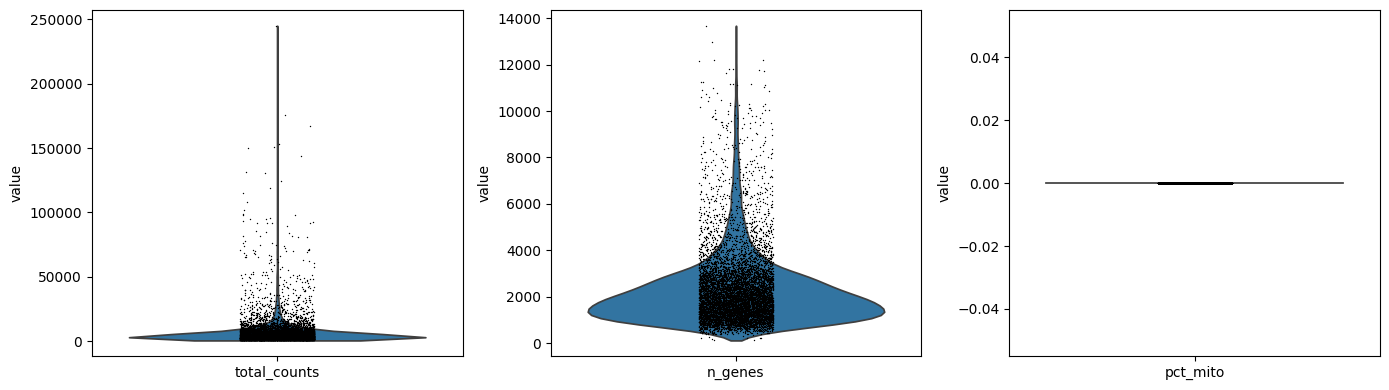

In [ ]:
# 5) Visualize QC distributions (choose thresholds after inspection)
fig, axes = plt.subplots(1,3, figsize=(14,4))
sc.pl.violin(filtered, keys='total_counts', groupby=None, show=False, ax=axes[0])
sc.pl.violin(filtered, keys='n_genes', groupby=None, show=False, ax=axes[1])
sc.pl.violin(filtered, keys='pct_mito', groupby=None, show=False, ax=axes[2])
plt.tight_layout()


## Filter Genes

In [ ]:
# 6) Suggested filtering (defaults — tune these per distributions and snRNA vs scRNA)
# NOTE: your meta.sample_type shows 'snRNAseq' — mitochondrial percentage often differs for nuclei (lower),
# so inspect distributions before aggressive mito filtering. These are starting suggestions.

min_genes = 200          # cells with <200 genes -> drop
min_counts = 500         # cells with <500 counts -> drop
max_counts = np.percentile(filtered.obs['total_counts'], 99.9)  # remove extremely high outliers
pct_mito_thresh = 10.0   # conservative for snRNA; increase for scRNA if needed (often 20%)

mask = (
    (filtered.obs['n_genes'] >= min_genes) &
    (filtered.obs['total_counts'] >= min_counts) &
    (filtered.obs['total_counts'] <= max_counts) &
    (filtered.obs['pct_mito'] <= pct_mito_thresh)
)

print("Cells before:", filtered.n_obs)
filtered = filtered[mask].copy()
print("Cells after:", filtered.n_obs)


Cells before: 8877
Cells after: 8865


In [31]:
# 7) Filter genes: remove genes expressed in very few cells
min_cells = 3
sc.pp.filter_genes(filtered, min_cells=min_cells)
print("Vars after filtering:", filtered.n_vars)


filtered out 9492 genes that are detected in less than 3 cells
Vars after filtering: 22793


In [33]:
filtered

AnnData object with n_obs × n_vars = 8877 × 22793
    obs: 'animal_species', 'sex', 'age', 'tissue_type', 'treatment', 'processing_date', 'sample_type', 'total_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'pct_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    obsm: 'X_scar'
    layers: 'counts_raw', 'denoised'

## Doublet Detection

Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:01)
Embedding transcriptomes using PCA...


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


    using data matrix X directly
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = nan%
    Scrublet finished (0:00:36)
                    doublet_score  predicted_doublet
AAACCCAAGGAAGTGA-1       0.010624              False
AAACCCACACTACAGT-1       0.092819              False
AAACCCACAGGTGGAT-1       0.033095              False
AAACCCAGTCGTACTA-1       0.043463              False
AAACCCATCGTTACCC-1       0.033095              False


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/preprocessing/_scrublet/core.py:461: RuntimeWarning: invalid value encountered in scalar divide
  self.detected_doublet_rate_ / self.detectable_doublet_fraction_


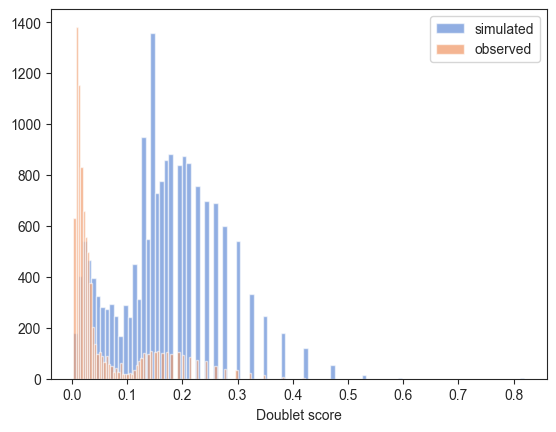

Kept / dropped cells: 8877 0


In [37]:
import scanpy as sc
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

adata = filtered            # your AnnData
layer = 'totla_counts'            # change if your raw counts are in a different layer

# 1. Pull the counts matrix from the layer (dense required)
counts_mat = adata.layers[layer] if layer in adata.layers else adata.X
if sp.issparse(counts_mat):
    counts_mat = counts_mat.toarray()   # convert to dense (watch memory)

# 2. Temporarily swap adata.X so scanpy.pp.scrublet uses the correct counts
original_X = adata.X
adata.X = counts_mat

# 3. Run scrublet wrapper (tune expected_doublet_rate as needed)
# Typical expected_doublet_rate: 0.03 - 0.08 (use higher if you attempted to recover many cells)
sc.pp.scrublet(
    adata,
    sim_doublet_ratio=2.0,
    expected_doublet_rate=0.06,  # <-- tune this per your experiment
    threshold=.95,
    n_prin_comps=30,
    normalize_variance=True,
    log_transform=False,
    mean_center=True,
    random_state=0
)

# 4. Inspect results (scanpy will add obs columns)
print(adata.obs[['doublet_score', 'predicted_doublet']].head())

# 5. Optional: histogram of observed scores (and simulated if scanpy stored it)
if 'scrublet' in adata.uns and 'doublet_scores_sim' in adata.uns['scrublet']:
    sim = adata.uns['scrublet']['doublet_scores_sim']
    obs = adata.obs['doublet_score'].values
    plt.hist(sim, bins=100, alpha=0.6, label='simulated')
    plt.hist(obs, bins=100, alpha=0.6, label='observed')
    plt.legend(); plt.xlabel('Doublet score')
else:
    plt.hist(adata.obs['doublet_score'].values, bins=100)
plt.show()

# 6. Restore original X (IMPORTANT)
adata.X = original_X

# 7. Remove predicted doublets (make a cleaned copy)
keep_mask = ~adata.obs['predicted_doublet'].astype(bool)
adata_no_doublets = adata[keep_mask].copy()
print("Kept / dropped cells:", adata_no_doublets.n_obs, (~keep_mask).sum())


In [53]:
filtered

AnnData object with n_obs × n_vars = 8877 × 22793
    obs: 'animal_species', 'sex', 'age', 'tissue_type', 'treatment', 'processing_date', 'sample_type', 'total_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'pct_mito', 'doublet_score', 'predicted_doublet', 'sample_ID', 'pANN', 'pANN_rank', 'DF.class'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet', 'pca', 'neighbors'
    obsm: 'X_scar', 'X_pca'
    varm: 'PCs'
    layers: 'counts_raw', 'denoised'
    obsp: 'distances', 'connectivities'

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


computing PCA
    with n_comps=50


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")


    finished (0:00:00)
computing neighbors


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


    finished (0:00:00)
computing UMAP
    finished (0:00:07)


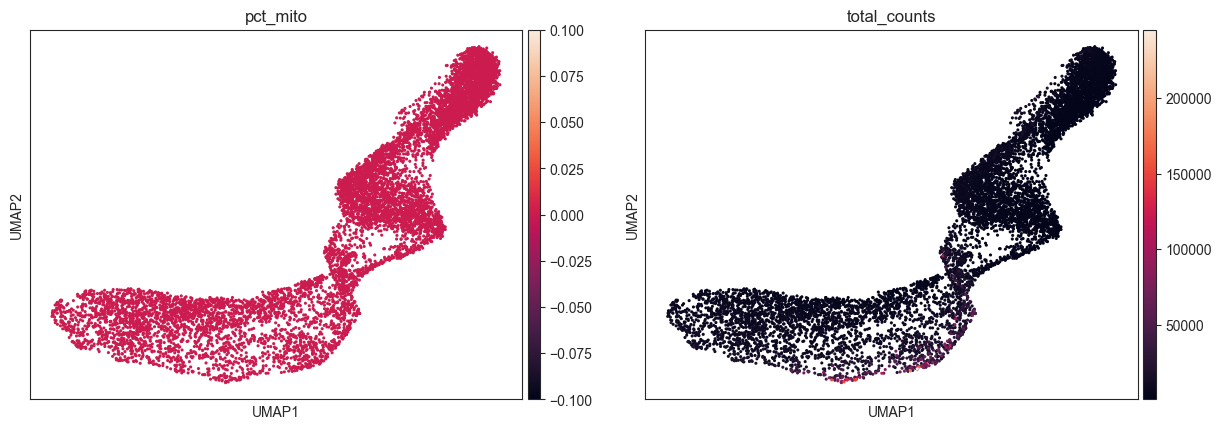

In [56]:
# assume filtered.layers['denoised_counts'] exists (from SCAR)
import scanpy as sc
import numpy as np
import scipy.sparse as sp

adata = filtered.copy()

# choose denoised layer as working data
adata.layers['denoised'] = adata.layers['denoised']  # if not already set

# normalize + log for PCA/UMAP (these steps are for visualization only)
sc.pp.normalize_total(adata, target_sum=1e4, layer='denoised', inplace=True)
sc.pp.log1p(adata, layer='denoised')

# compute HVGs on denoised (optional)
sc.pp.highly_variable_genes(adata, layer='denoised', n_top_genes=2000, flavor='seurat_v3', inplace=True)

# run PCA on denoised expression (use .X from layer via view_array)
# easiest: create a temporary adata_hvg with denoised data
if 'highly_variable' in adata.var.columns:
    adata_hvg = adata[:, adata.var['highly_variable']].copy()
else:
    adata_hvg = adata.copy()

# copy layer to X for downstream sc.pp functions
adata_hvg.X = adata_hvg.layers['denoised'] if 'denoised' in adata_hvg.layers else adata_hvg.X

sc.pp.scale(adata_hvg, max_value=10)
sc.tl.pca(adata_hvg, n_comps=50)
sc.pp.neighbors(adata_hvg, n_neighbors=15, use_rep='X_pca')
sc.tl.umap(adata_hvg, min_dist=0.3)

sc.pl.umap(adata_hvg, color=['pct_mito','total_counts'], size=20)


Processing sample: 7Dataset n_cells: 8877
n_cells=8877, n_genes=22793, sim_doublets=17754
Using k_neighbors=89 for kNN
Marked 533 cells as Doublets (expected_doublet_rate=0.06)
computing neighbors
    using 'X_pca' with n_pcs = 50


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


    finished (0:00:00)
computing UMAP
    finished (0:00:16)


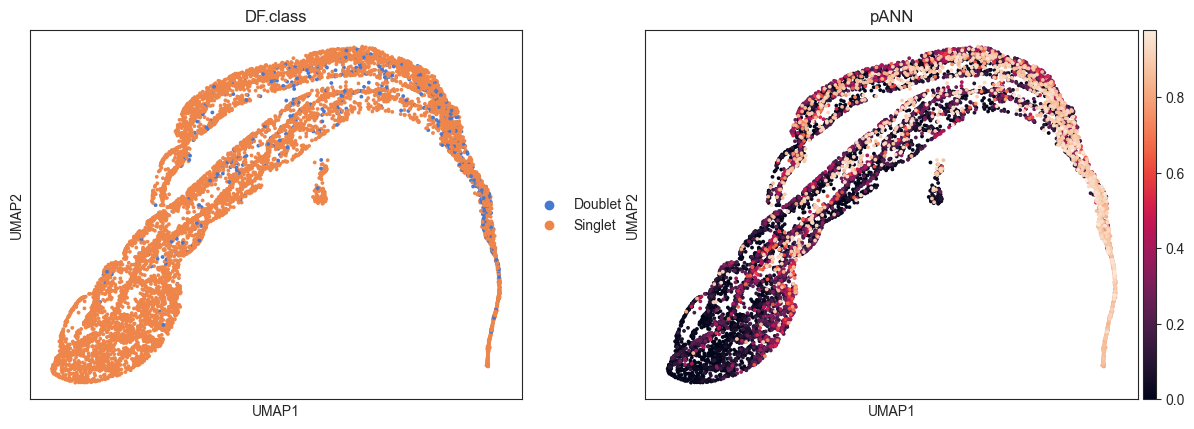

In [58]:
import numpy as np
import scipy.sparse as sp
import pandas as pd
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neighbors import NearestNeighbors
import scanpy as sc

def simulate_doublets(counts, n_doublets, rng=None):
    """Simulate doublets by summing two randomly chosen cell profiles (raw counts)."""
    rng = np.random.default_rng(rng)
    n_cells = counts.shape[0]
    idx1 = rng.integers(0, n_cells, size=n_doublets)
    idx2 = rng.integers(0, n_cells, size=n_doublets)
    # if sparse, convert slices to dense before summing
    if sp.issparse(counts):
        d = counts[idx1].toarray() + counts[idx2].toarray()
    else:
        d = counts[idx1] + counts[idx2]
    return d

def compute_pANN_for_adata(adata, layer='counts', sim_doublet_ratio=2.0, expected_doublet_rate=0.06,
                           n_pcs=30, k_neighbors=None, random_state=0, verbose=True):
    """
    Compute pANN (proportion of artificial nearest neighbors) and DF.class labels for adata.
    Returns adata with new obs columns: 'pANN' and 'DF.class' ('Doublet'/'Singlet').
    """
    # 1) get counts matrix
    counts = adata.layers[layer] if layer in adata.layers else adata.X
    if sp.issparse(counts):
        # For preprocessing we'll use dense on per-sample basis - convert but be mindful of memory
        counts = counts.toarray()

    n_cells, n_genes = counts.shape
    n_doublets = int(np.round(sim_doublet_ratio * n_cells))
    if verbose:
        print(f"n_cells={n_cells}, n_genes={n_genes}, sim_doublets={n_doublets}")

    # 2) simulate artificial doublets
    simd = simulate_doublets(counts, n_doublets=n_doublets, rng=random_state)

    # 3) concatenate real + artificial for preprocessing and PCA
    combined = np.vstack([counts, simd])  # shape (n_cells + n_doublets, n_genes)

    # 4) simple preprocessing: normalize_total -> log1p -> scale by gene (mean center)
    # We'll follow common practice: normalize by total UMI per cell then log1p.
    libsize = combined.sum(axis=1, keepdims=True)
    libsize[libsize == 0] = 1.0
    combined_norm = (combined / libsize) * 1e4
    combined_log = np.log1p(combined_norm)

    # optional: center genes (column mean)
    combined_log -= combined_log.mean(axis=0, keepdims=True)

    # 5) PCA (use TruncatedSVD for big sparse, but we now have dense)
    if n_pcs >= min(combined_log.shape):
        n_pcs = min(combined_log.shape) - 1
    pca = PCA(n_components=n_pcs, random_state=random_state)
    pcs = pca.fit_transform(combined_log)
    # split back
    pcs_real = pcs[:n_cells, :]
    pcs_sim = pcs[n_cells:, :]

    # 6) choose k for neighbors: default ~ max(10, round(0.01 * n_cells))
    if k_neighbors is None:
        k = max(10, int(round(0.01 * n_cells)))
    else:
        k = int(k_neighbors)
    if verbose:
        print(f"Using k_neighbors={k} for kNN")

    # 7) compute neighbors on combined PCs (this mirrors DoubletFinder embedding + neighborhood)
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(pcs)
    distances, indices = nbrs.kneighbors(pcs_real)  # neighbors for real cells (rows are real indices)

    # 8) compute pANN: fraction of neighbors that are simulated doublets
    # indices contains indices into combined array (0..n_cells+n_doublets-1)
    is_sim_mask = np.arange(n_cells + n_doublets) >= n_cells
    # for each real cell, compute proportion of its k neighbors that are simulated
    pANN = np.mean(is_sim_mask[indices], axis=1)

    # 9) classify using expected doublet rate: top N pANN cells flagged as Doublet
    n_expected = int(np.round(expected_doublet_rate * n_cells))
    if n_expected < 1:
        n_expected = 1  # ensure at least one if tiny
    # rank descending, pick top n_expected as doublets
    order = np.argsort(-pANN)  # descending
    doublet_idx = order[:n_expected]
    labels = np.array(['Singlet'] * n_cells)
    labels[doublet_idx] = 'Doublet'

    # 10) put results into adata.obs
    adata.obs['pANN'] = pANN
    adata.obs['pANN_rank'] = np.argsort(np.argsort(-pANN)) + 1  # 1 = highest pANN
    adata.obs['DF.class'] = labels

    if verbose:
        print(f"Marked {n_expected} cells as Doublets (expected_doublet_rate={expected_doublet_rate})")
    return adata

# -------------------------
# Example: run per-sample (recommended)
# -------------------------
layer = 'counts_raw'
batch_key = 'sample_ID'  # change if different
for sample in filtered.obs[batch_key].unique():
    mask = filtered.obs[batch_key] == sample
    ad = filtered[mask].copy()
    print("Processing sample:", sample, "n_cells:", ad.n_obs)
    ad = compute_pANN_for_adata(ad, layer=layer, sim_doublet_ratio=2.0, expected_doublet_rate=0.06,
                                n_pcs=30, k_neighbors=None, random_state=0, verbose=True)
    # write back results
    filtered.obs.loc[mask, 'pANN'] = ad.obs['pANN'].values
    filtered.obs.loc[mask, 'pANN_rank'] = ad.obs['pANN_rank'].values
    filtered.obs.loc[mask, 'DF.class'] = ad.obs['DF.class'].values

# Visual checks
sc.pp.neighbors(filtered, use_rep=None)  # use current adata.X's usual pipeline (or compute UMAP beforehand)
# If you already have a UMAP computed on your data, just plot:
sc.tl.umap(filtered, min_dist=0.3)
sc.pl.umap(filtered, color=['DF.class', 'pANN'], size=30)


In [62]:
filtered

AnnData object with n_obs × n_vars = 8877 × 22793
    obs: 'animal_species', 'sex', 'age', 'tissue_type', 'treatment', 'processing_date', 'sample_type', 'total_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'pct_mito', 'doublet_score', 'predicted_doublet', 'sample_ID', 'pANN', 'pANN_rank', 'DF.class'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet', 'pca', 'neighbors', 'umap', 'DF.class_colors'
    obsm: 'X_scar', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts_raw', 'denoised'
    obsp: 'distances', 'connectivities'

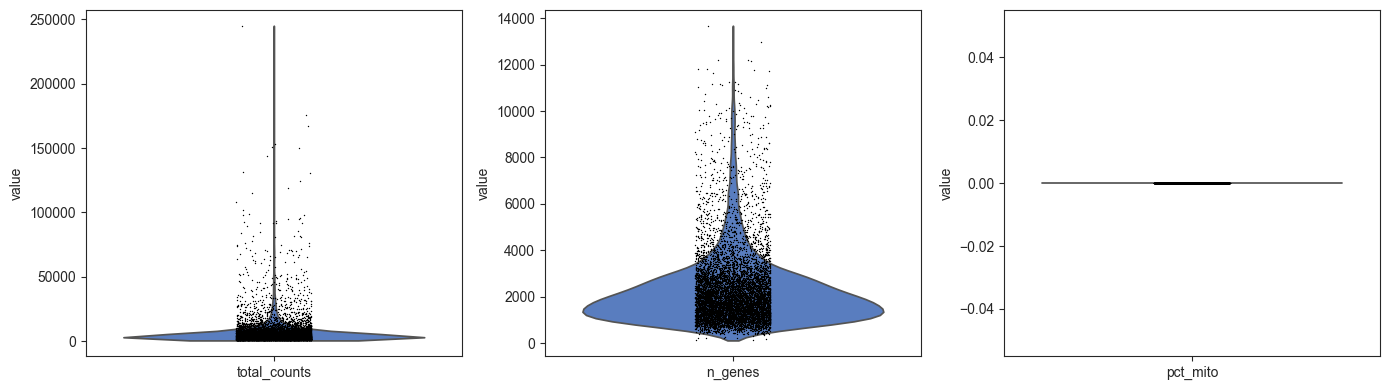

In [66]:
fig, axes = plt.subplots(1,3, figsize=(14,4))
sc.pl.violin(filtered, keys='total_counts', groupby=None, show=False, ax=axes[0])
sc.pl.violin(filtered, keys='n_genes', groupby=None, show=False, ax=axes[1])
sc.pl.violin(filtered, keys='pct_mito', groupby=None, show=False, ax=axes[2])
plt.tight_layout()

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


HVGs: 2000
computing PCA
    with n_comps=40
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


    finished (0:00:00)
running Leiden clustering
    finished (0:00:01)
computing UMAP
    finished (0:00:08)


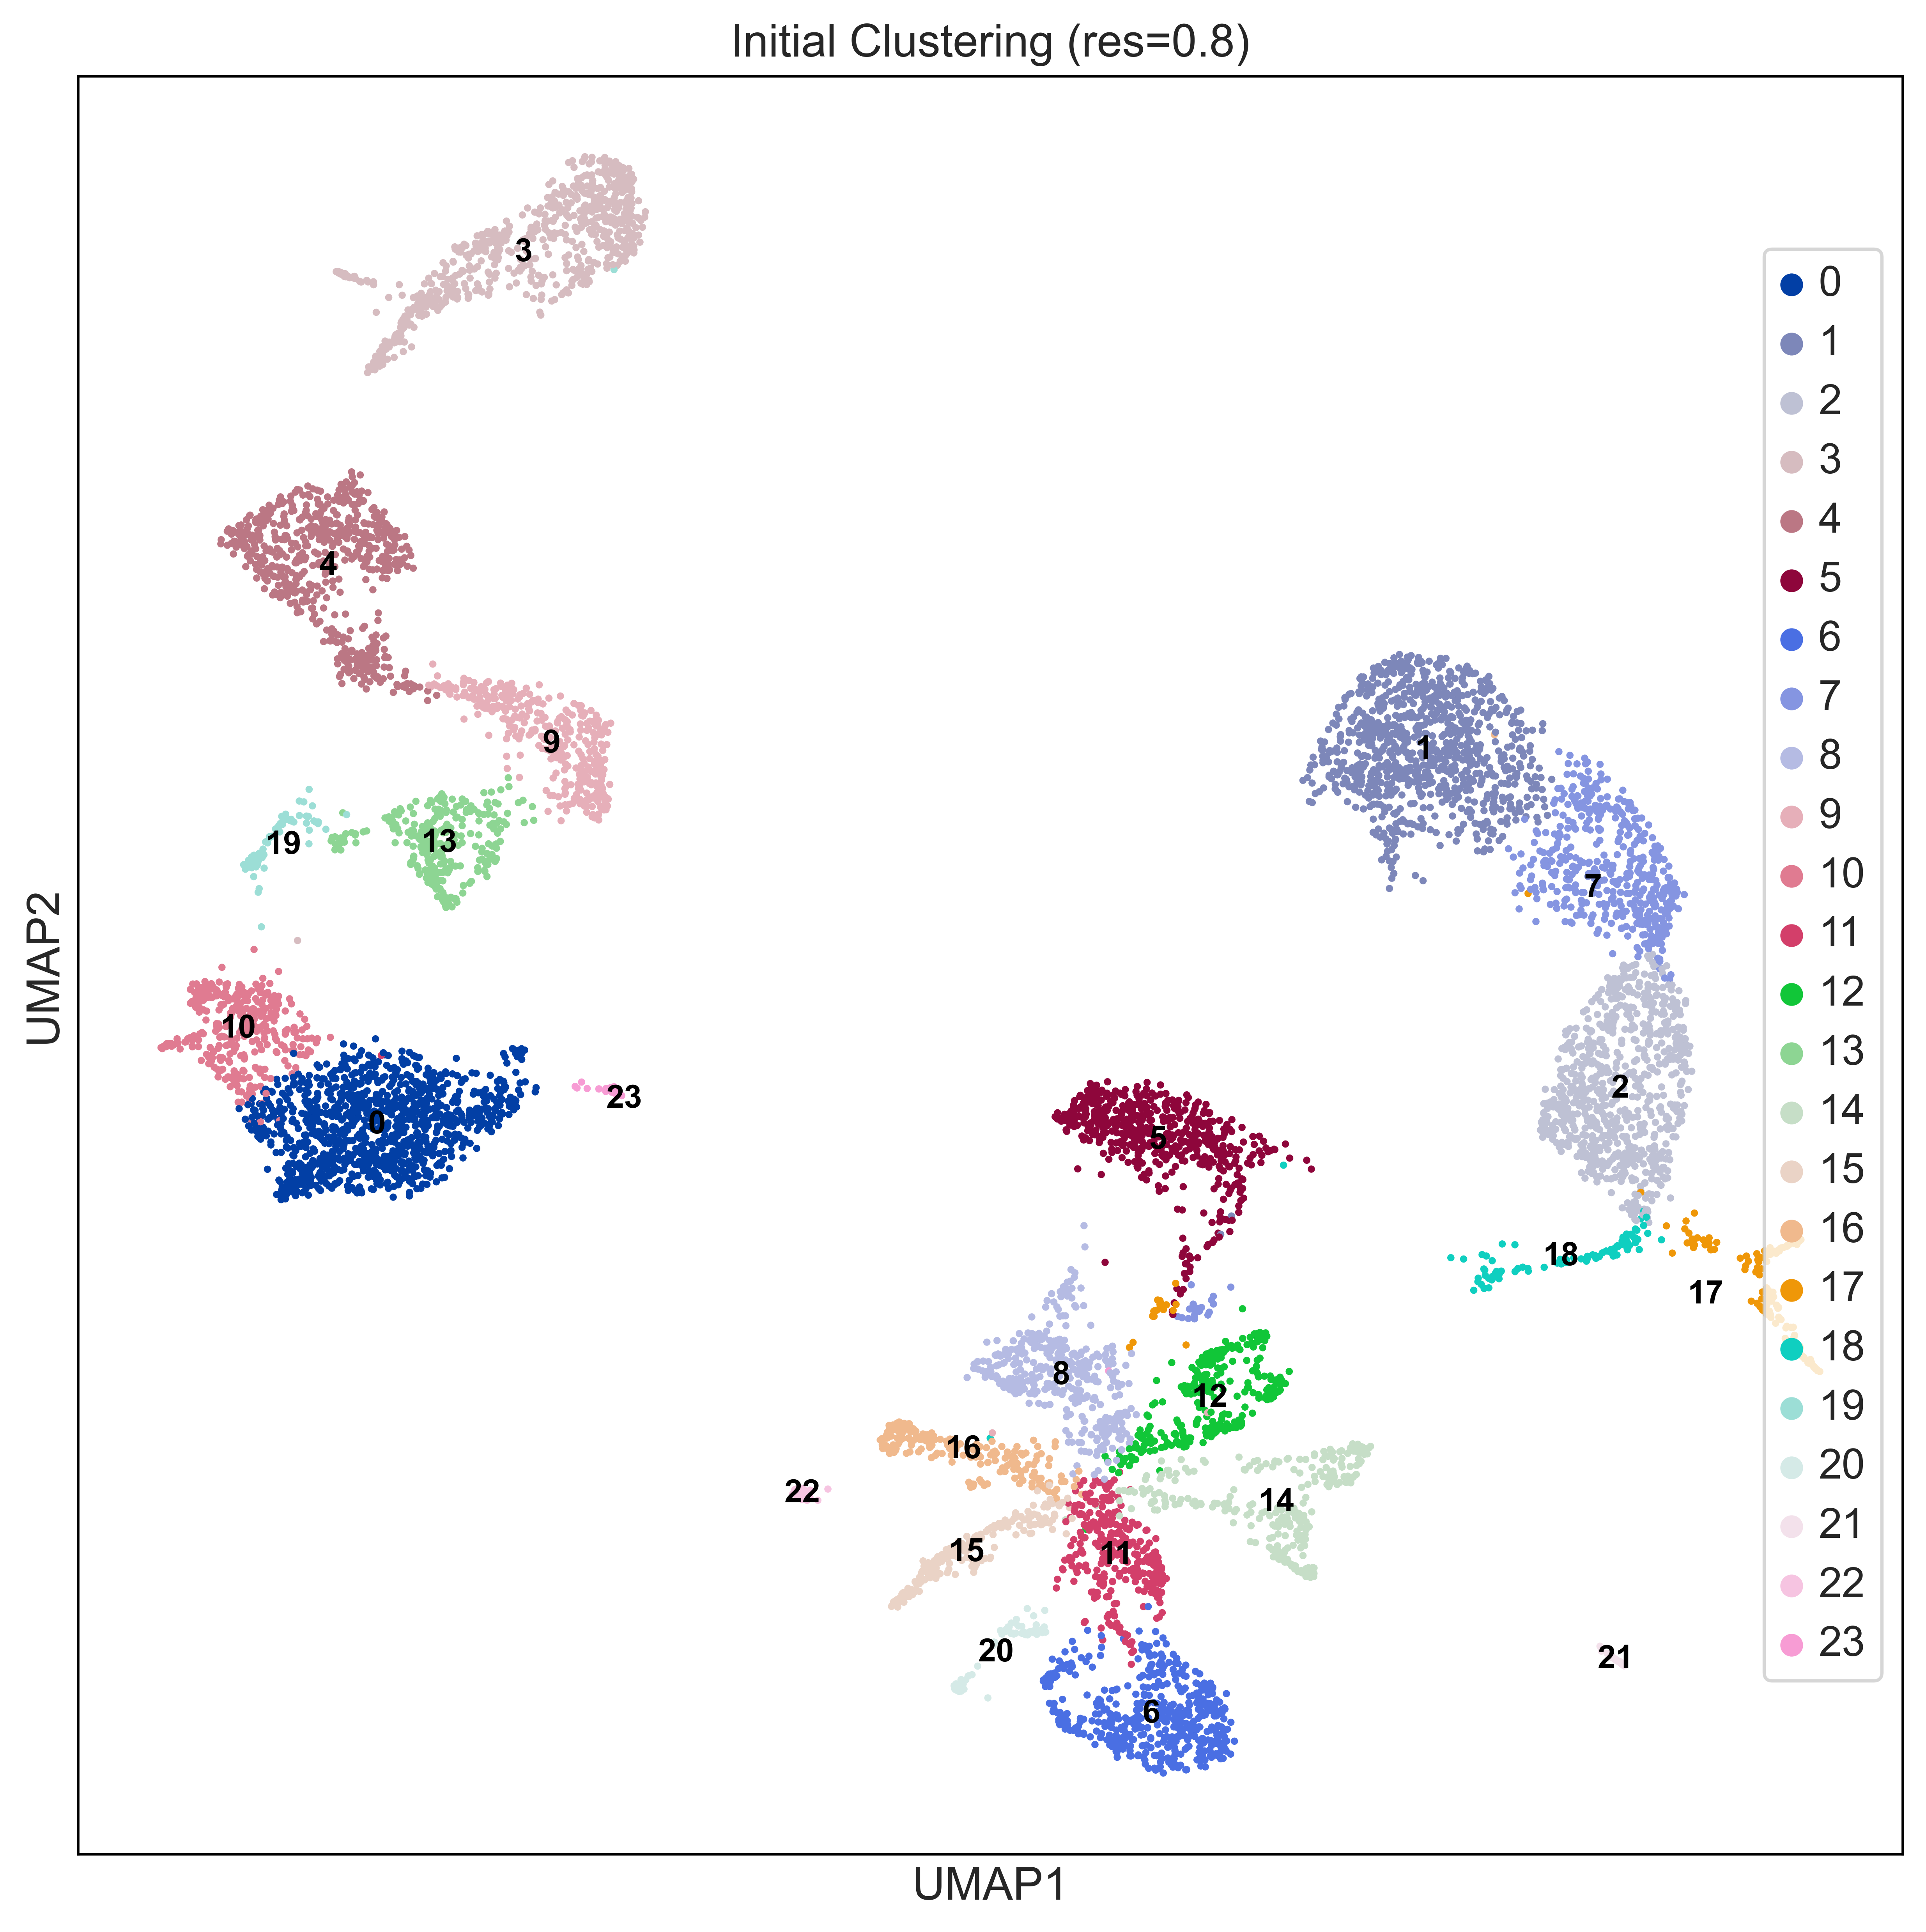

In [70]:
# Scanpy pipeline that mirrors the Seurat code and produces UMAP with cluster number labels
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

adata = filtered.copy()   # use your AnnData (filtered or filtered_no_doublets)
sc.settings.set_figure_params(dpi=300, figsize=(10,10))

# 1) Normalize & log (Seurat: NormalizeData)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# 2) Find variable features (Seurat: FindVariableFeatures)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3', subset=False)
print("HVGs:", adata.var['highly_variable'].sum())

# Optionally subset to HVGs for speed (Seurat later uses HVGs for PCA)
use_hvgs = True
if use_hvgs:
    adata_hvg = adata[:, adata.var['highly_variable']].copy()
else:
    adata_hvg = adata.copy()

# 3) Scale (Seurat: ScaleData)
sc.pp.scale(adata_hvg, max_value=10)

# 4) PCA (Seurat: RunPCA)
n_pcs = 40
sc.tl.pca(adata_hvg, n_comps=n_pcs, svd_solver='arpack')

# 5) Neighbors (Seurat: FindNeighbors using dims = 1:40)
sc.pp.neighbors(adata_hvg, n_neighbors=15, n_pcs=n_pcs)

# 6) Clustering (Seurat: FindClusters)
# use Leiden; resolution controls cluster granularity (like Seurat's resolution)
resolution = 0.8
sc.tl.leiden(adata_hvg, resolution=resolution, key_added='leiden')

# 7) UMAP (Seurat: RunUMAP)
sc.tl.umap(adata_hvg, min_dist=0.3)

# 8) Plot UMAP colored by cluster
sc.pl.umap(adata_hvg, color='leiden', legend_loc='right', title=f"Initial Clustering (res={resolution})", size=20, show=False)

# 9) Add cluster number labels at cluster centroids (like Seurat DimPlot(label=TRUE))
# compute centroid for each cluster in the UMAP embedding and overlay text
umap_coords = adata_hvg.obsm['X_umap']
clusters = adata_hvg.obs['leiden'].astype(str)
unique_clusters = np.unique(clusters)

# draw text labels
ax = plt.gca()
for cl in unique_clusters:
    mask = clusters == cl
    x, y = umap_coords[mask, :].mean(axis=0)
    ax.text(x, y, cl, color='black', fontsize=10, weight='bold',
            horizontalalignment='center', verticalalignment='center')

plt.show()


## Save new counts

In [ ]:
# 9) Save a copy of counts in layers and save raw counts for reference
filtered.layers['counts'] = filtered.X.copy()    # keep count matrix
filtered.raw = filtered  # if you want the post-filter but pre-normalization raw snapshot

# Save h5ad
#filtered.write_h5ad("7_filtered_qc.h5ad")
